# Model Validation Test

data set $(x,y)^d$, where $y_i=\{1, 0\}^L$

we want to map y into lower space by $$z = [M\cdot y]$$ where M is a multivariant i,i,d Gaussian matrix, and $[]$ is tkaing the sign.

Then we train binary classifiers on each bit of $z \in \{0, 1\}^{\hat L}$

For each test point, we predict its $\hat z$ and then use kNN to find the nearest k neighbors from $z=[My]$ which is all our lower degree space's mapping.

## Target:

* Test relationship between p@k in $y \in \{0, 1\}^L$ and bit flip probability in $z \in \{0, 1\}^{\hat L}$ space

* ...


## Data Preprocess

In [2]:
%matplotlib inline
import math
import os
%matplotlib inline
import math
import os
import data_util
import BMapModel
#from data_util import DataPoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import faiss
import util
import scipy
# import joblib # version incompatibel with sklearn's joblib and can't load the previous model

from scipy.sparse import save_npz, load_npz
from scipy import sparse
from sklearn.externals import joblib # store classifiers
from sklearn.preprocessing import MultiLabelBinarizer # convert y to {0,1}^L
from sklearn.preprocessing import StandardScaler # normalize features 
from sklearn.feature_extraction import DictVectorizer # extract feature vector to x
from numpy.random import normal # generate transforming matrix
from sklearn.neighbors import KDTree #KDTree for fast kNN search
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import average_precision_score
from joblib import Parallel, delayed # Multitread
from pytictoc import TicToc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

Failed to load GPU Faiss: No module named swigfaiss_gpu
Faiss falling back to CPU-only.


In [3]:
!ls -R ../data

../data:
AmazonCat	   Bibtex	   Eurlex     README_Datasets
AmazonCat-14K	   Delicious	   Mediamill  Wiki10
AmazonCat-14K.zip  DeliciousLarge  RCV1-x     XMLDatasetRead

../data/AmazonCat:
amazonCat_test.txt  amazonCat_train.txt  X_te.npz  X_tr.npz  Y_te.npz  Y_tr.npz

../data/AmazonCat-14K:
amazonCat-14K_test.txt	amazonCat-14K_train.txt

../data/Bibtex:
Bibtex_data.txt     bibtex_tstSplit.txt  X_tr.npz  Y_tr.npz
bibtex_trSplit.txt  X_te.npz		 Y_te.npz

../data/Delicious:
Delicious_data.txt	X_te.npz  X_tr.pkl  Y_tr.npz
delicious_trSplit.txt	X_te.pkl  Y_te.npz  Y_tr.pkl
delicious_tstSplit.txt	X_tr.npz  Y_te.pkl

../data/DeliciousLarge:
deliciousLarge_test.txt   X_te.npz  Y_te.npz
deliciousLarge_train.txt  X_tr.npz  Y_tr.npz

../data/Eurlex:
eurlex_test.txt  eurlex_train.txt  X_te.npz  X_tr.npz  Y_te.npz  Y_tr.npz

../data/Mediamill:
Mediamill_data.txt  mediamill_trSplit.txt  mediamill_tstSplit.txt

../data/RCV1-x:
rcv1x_test.txt	rcv1x_train.txt  X_te.pkl  X_tr.pkl  Y_te.pkl  Y_tr.pkl

..

In [4]:
ls ../data/Wiki10/

wiki10_test.txt*   X_te.npz  X_tr.npz  Y_te.npz  Y_tr.npz
wiki10_train.txt*  X_te.pkl  X_tr.pkl  Y_te.pkl  Y_tr.pkl


In [5]:
data_dir = "../data"
model_dir = "../model/model6"
train_filename = "/Delicious/Delicious_data.txt"
#test_filename = "/Eurlex/eurlex_test.txt"
tr_split_file = "/Delicious/delicious_trSplit.txt"
te_split_file = "/Delicious/delicious_tstSplit.txt"

path = '/Wiki10'
model_path = model_dir + path
data_path = data_dir + path
num_core = -1
L_hat_ratio = 0.5
L_hat = 100
time = TicToc()

In [6]:
[X_tr, X_te, Y_tr, Y_te] = [load_npz(os.path.join(data_path, '{}.npz'.format(name)))\
                            for name in ['X_tr', 'X_te', 'Y_tr', 'Y_te']]

In [7]:
X_tr.shape, X_te.shape, Y_tr.shape, Y_te.shape

((14146, 101850), (6616, 101850), (14146, 30938), (6616, 30938))

### Step 1: map to $\hat L$ space and kNN search index

We apply $$\hat L = k \log L$$ where $k$ indicates the sparsity of each label vector $y_i = \{0,1\}^L$. By default we choose k to be the 99.9% maximum sparsity to avoid extreme cases.

The data in "Eurlex" contains $L = 5000$ labels, we are trying to map it into $\hat L = 200$ space.

In [8]:
k = sorted([Y.sum() for Y in Y_tr], reverse=True)[int(X_tr.shape[0]*0.0001)]
k

30

In [9]:
#L_hat = int(math.ceil(k * math.log(Y_tr.shape[1], 2) * L_hat_ratio))
L_hat

100

In [10]:
Z_tr = util.map_2_z(Y_tr, L_hat)
Z_te = util.map_2_z(Y_te, L_hat)

In [11]:
nn_index = faiss.index_factory(Z_tr.shape[1], "Flat", faiss.METRIC_L2)   # build the index
nn_index.add(Z_tr.astype('float32'))

### Experiment 1: Simulate noisy model to see the change w.p.t p@k on y

* randomly flip every bit in Z_tr w/ prob p and then use kNN to test p@1, simulation 1000 times for every point

* randomly flip every "1" w/ prob p1, and every "0" w/ p0 in Z_tr, ...


In [43]:
def flip_bits(message, p0, p1):
    '''
    randomly flip every "1" w/ prob p1, and every "0" w/ p0
    '''
    def flip(bit):
        if bit==1 and np.random.rand()<p1:
            bit = 0
        if bit==0 and np.random.rand()<p0:
            bit=1
        return bit
    np.random.seed(0)
    return np.apply_along_axis(lambda bits: np.array([flip(bit) for bit in bits]), 0, message)


In [44]:
def simulation_p_at_k(p0, p1, vote=20, pk=1, iteration=10):
    precision = []
    for _ in range(iteration):
        z_pred = flip_bits(Z_te, p0, p1)
        dist, ind = nn_index.search(z_pred.astype('float32'), vote)
        Y_pred =  [np.sum([Y_tr[indij]/float(distij*distij+0.01) \
                           for indij, distij in zip(indi, disti)]) \
                   for indi, disti in zip(ind,dist)]
        precision.append(util.precision_at_k(Y_te, Y_pred, pk))
    return np.mean(precision)

In [45]:
p_at_k = Parallel(n_jobs=num_core)\
    (delayed(simulation_p_at_k)(j, i) for j in np.arange(0, 0.6, 0.1) for i in np.arange(0, 0.6, 0.1))

In [46]:
p_at_k_2d = np.array(p_at_k).reshape(6, 6)

In [47]:
x_grid = np.arange(0, 0.6, 0.1)
x_grid, y_grid = np.meshgrid(x_grid, x_grid)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x_grid, y_grid, p_at_k_2d)
ax.view_init(30, 70)
plt.xlabel('p1')
plt.ylabel('p0')
plt.title('bit flip prob vs p@1')

ValueError: Unknown projection '3d'

In [ ]:
p_at_k_1d = Parallel(n_jobs=num_core)\
    (delayed(simulation_p_at_k)(j, j) for j in np.arange(0, 0.6, 0.1))

In [ ]:
plt.plot(p_at_k_1d)
plt.xlabel('bit flip probability')
plt.ylabel('p@1')

### Experiment 2: test Binary Eraseral Model

* Use Random Forest classifier to predict a probability

* Threshold the probability into 0, 1, * (miss).

* calculate erasure rate and bit flip probability


In [12]:
model = BMapModel.BM_Predictor(Y_tr.shape[1], L_hat=1, index=nn_index, 
                               Y_tr=Y_tr, model_path=model_path)

In [13]:
z_pred_p = model.predict_prob_z(X_te)

In [38]:
z_pred = model.predict_z(X_te)

In [19]:
erasure_rate = []
bit_flip_rate = []
for margin in np.arange(0.1, 0.5, 0.01):
    z_threshold = np.apply_along_axis(lambda row: [0 if x < margin else 1 if x > 1-margin else np.nan for x in row], 
                                  axis=0, arr=z_pred_p)
    erasure_rate.append(np.isnan(z_threshold).sum()/float(z_threshold.shape[0] * z_threshold.shape[1]))
    bit_flip_rate.append(1-((z_threshold == Z_te).sum()/
                         float(z_threshold.shape[0] * z_threshold.shape[1]-np.isnan(z_threshold).sum())))

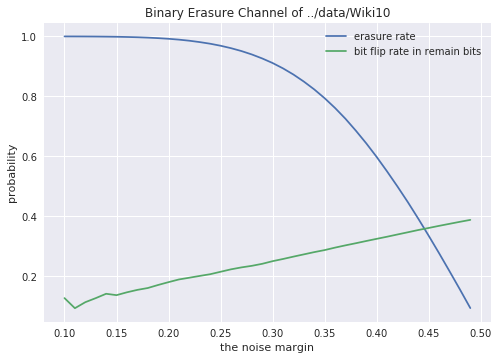

In [20]:
plt.plot(np.arange(0.1, 0.5, 0.01), erasure_rate, label='erasure rate')
plt.plot(np.arange(0.1, 0.5, 0.01), bit_flip_rate, label='bit flip rate in remain bits')
plt.xlabel('the noise margin')
plt.ylabel('probability')
plt.title('Binary Erasure Channel of {}'.format(data_path))
plt.legend()

In [35]:
z_pred_t = np.apply_along_axis(lambda row: [0 if x <= 0.5 else 1 if x > 0.5 else np.nan for x in row], 
                    axis=0, arr=z_pred_p)

In [36]:
1-(Z_te == z_pred_t).sum()/float(z_threshold.shape[0] * z_threshold.shape[1])

0.39761336154776294